<a href="https://colab.research.google.com/github/sjkim-audio/audio-dsp-lab/blob/main/notebooks/07_Advanced_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original SNR State: Noisy
Restored State: Denoised


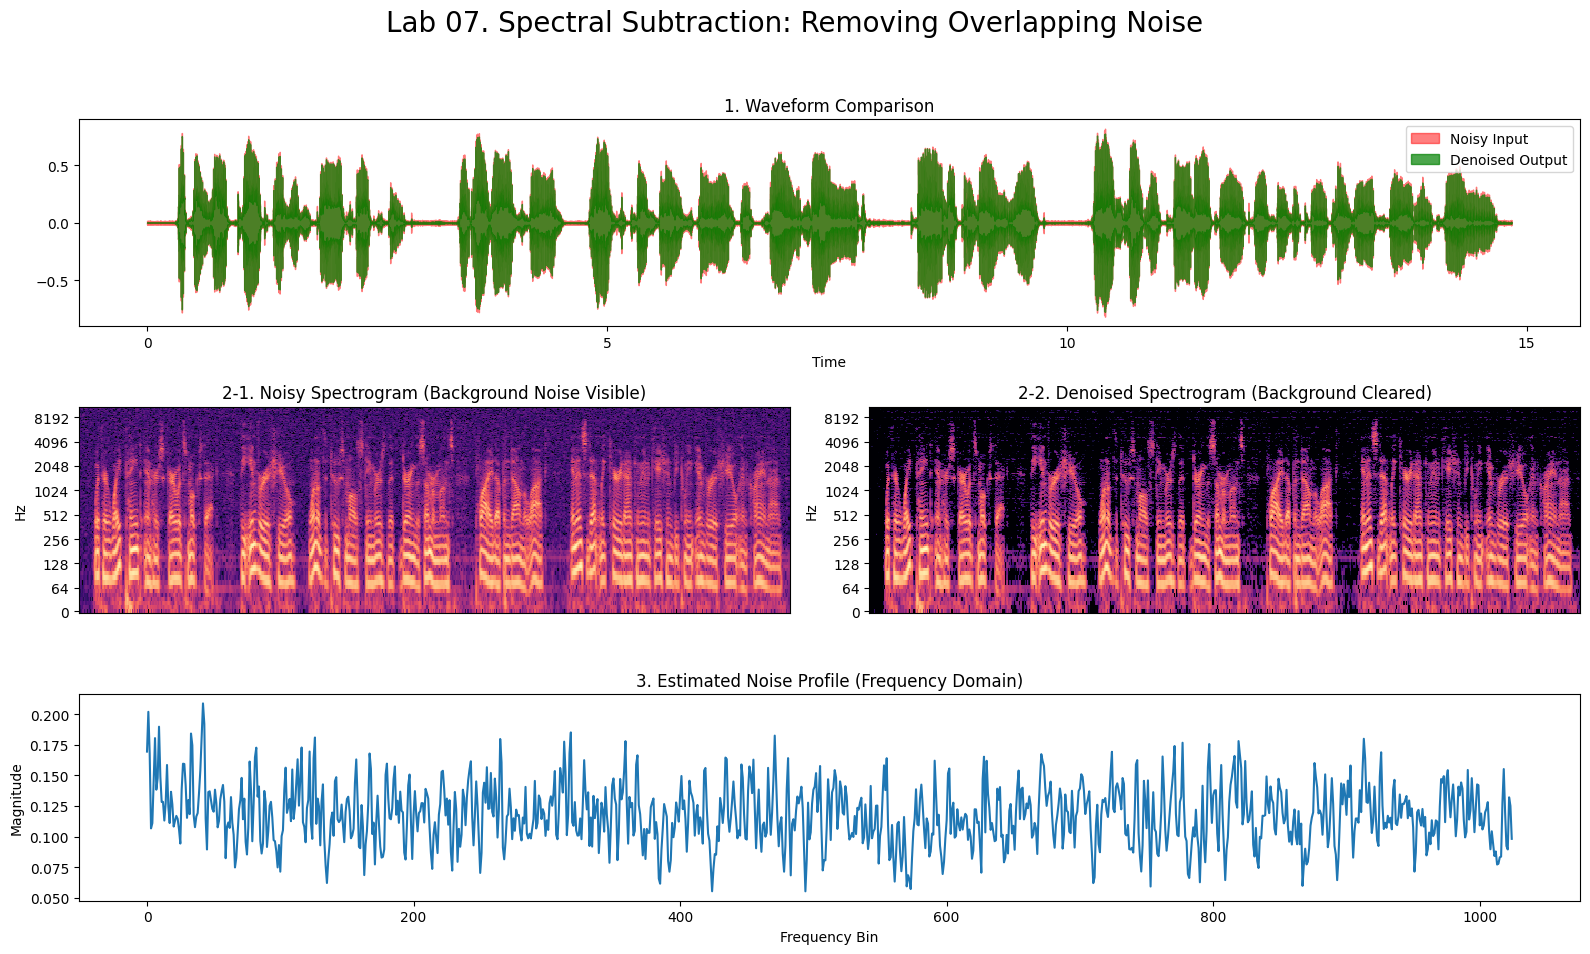

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# 1. 데이터 로드 및 노이즈 추가
# 깨끗한 원본 데이터 로드
filename = librosa.ex('libri1')
y, sr = librosa.load(filename)

# 화이트 노이즈 생성 및 합성 (SNR 저하)
noise = np.random.normal(0, 0.005, len(y))
y_noisy = y + noise

# 2. STFT 변환 (주파수 도메인으로 변환)
# 소리를 '크기(Magnitude)'와 '위상(Phase)'으로 분리함
# n_fft=2048, hop_length=512
S_full, phase = librosa.magphase(librosa.stft(y_noisy))

# 3. Noise Profiling (노이즈 특성 추정)
# 가정: 앞부분 0.3초 구간은 목소리가 없고 노이즈만 존재한다고 가정함
noise_sample_frames = int(0.3 * sr / 512) # 0.3초에 해당하는 프레임 수 계산
noise_profile = np.mean(S_full[:, :noise_sample_frames], axis=1, keepdims=True)

# 4. Spectral Subtraction (스펙트럼 차감)
# 전체 스펙트럼에서 노이즈 프로파일을 수학적으로 뺌
# alpha: 노이즈 제거 강도 (Over-subtraction factor)
alpha = 2.0
S_denoised = S_full - (alpha * noise_profile)

# 0보다 작은 값은 노이즈가 아니라 데이터 손실이므로 0으로 클리핑(Clipping)함
S_denoised = np.maximum(S_denoised, 0.0)

# 5. 역변환 (ISTFT) 및 복원
# 정제된 크기(Magnitude)에 기존의 위상(Phase)을 입혀서 오디오로 복원함
y_denoised = librosa.istft(S_denoised * phase)

# 결과 출력
print(f"Original SNR State: Noisy")
# ipd.Audio(y_noisy, rate=sr) # 노이즈 섞인 소리 듣기

print(f"Restored State: Denoised")
# ipd.Audio(y_denoised, rate=sr) # 복원된 소리 듣기

# 6. 결과 시각화
plt.figure(figsize=(16, 10))
plt.suptitle('Lab 07. Spectral Subtraction: Removing Overlapping Noise', fontsize=20)

# [Row 1] 파형 비교
plt.subplot(3, 1, 1)
librosa.display.waveshow(y_noisy, sr=sr, alpha=0.5, color='r', label='Noisy Input')
librosa.display.waveshow(y_denoised, sr=sr, alpha=0.7, color='g', label='Denoised Output')
plt.title('1. Waveform Comparison')
plt.legend()

# [Row 2] 노이즈 섞인 스펙트로그램
plt.subplot(3, 2, 3)
D_noisy = librosa.amplitude_to_db(S_full, ref=np.max)
librosa.display.specshow(D_noisy, y_axis='log', sr=sr)
plt.title('2-1. Noisy Spectrogram (Background Noise Visible)')

# [Row 3] 노이즈 제거된 스펙트로그램
plt.subplot(3, 2, 4)
D_denoised = librosa.amplitude_to_db(S_denoised, ref=np.max)
librosa.display.specshow(D_denoised, y_axis='log', sr=sr)
plt.title('2-2. Denoised Spectrogram (Background Cleared)')

# [Row 4] 노이즈 프로파일 (우리가 뺀 것)
plt.subplot(3, 1, 3)
plt.plot(noise_profile)
plt.title('3. Estimated Noise Profile (Frequency Domain)')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()